In [20]:
import os 
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

## Reading Data 

In [21]:
customer= pd.read_csv("../data/Mall_Customers.csv")
customer.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [22]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [23]:
customer.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## EDA

In [24]:
customer.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

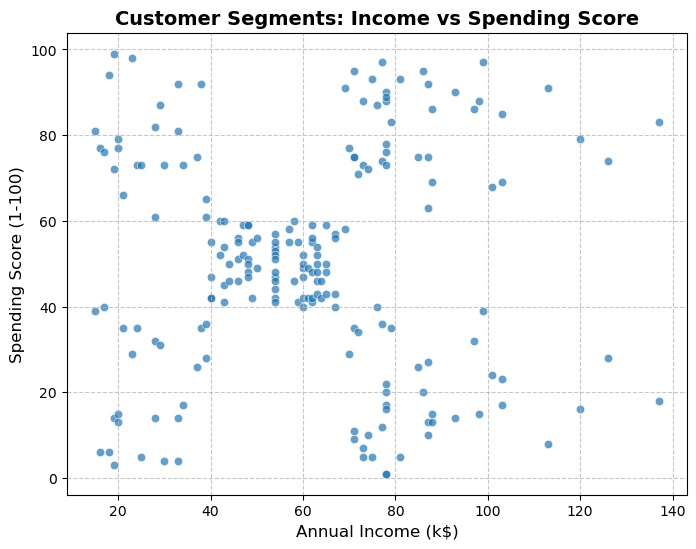

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(data= customer, x='Annual Income (k$)', y='Spending Score (1-100)', alpha=0.7)
plt.title('Customer Segments: Income vs Spending Score', fontsize=14, weight='bold')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


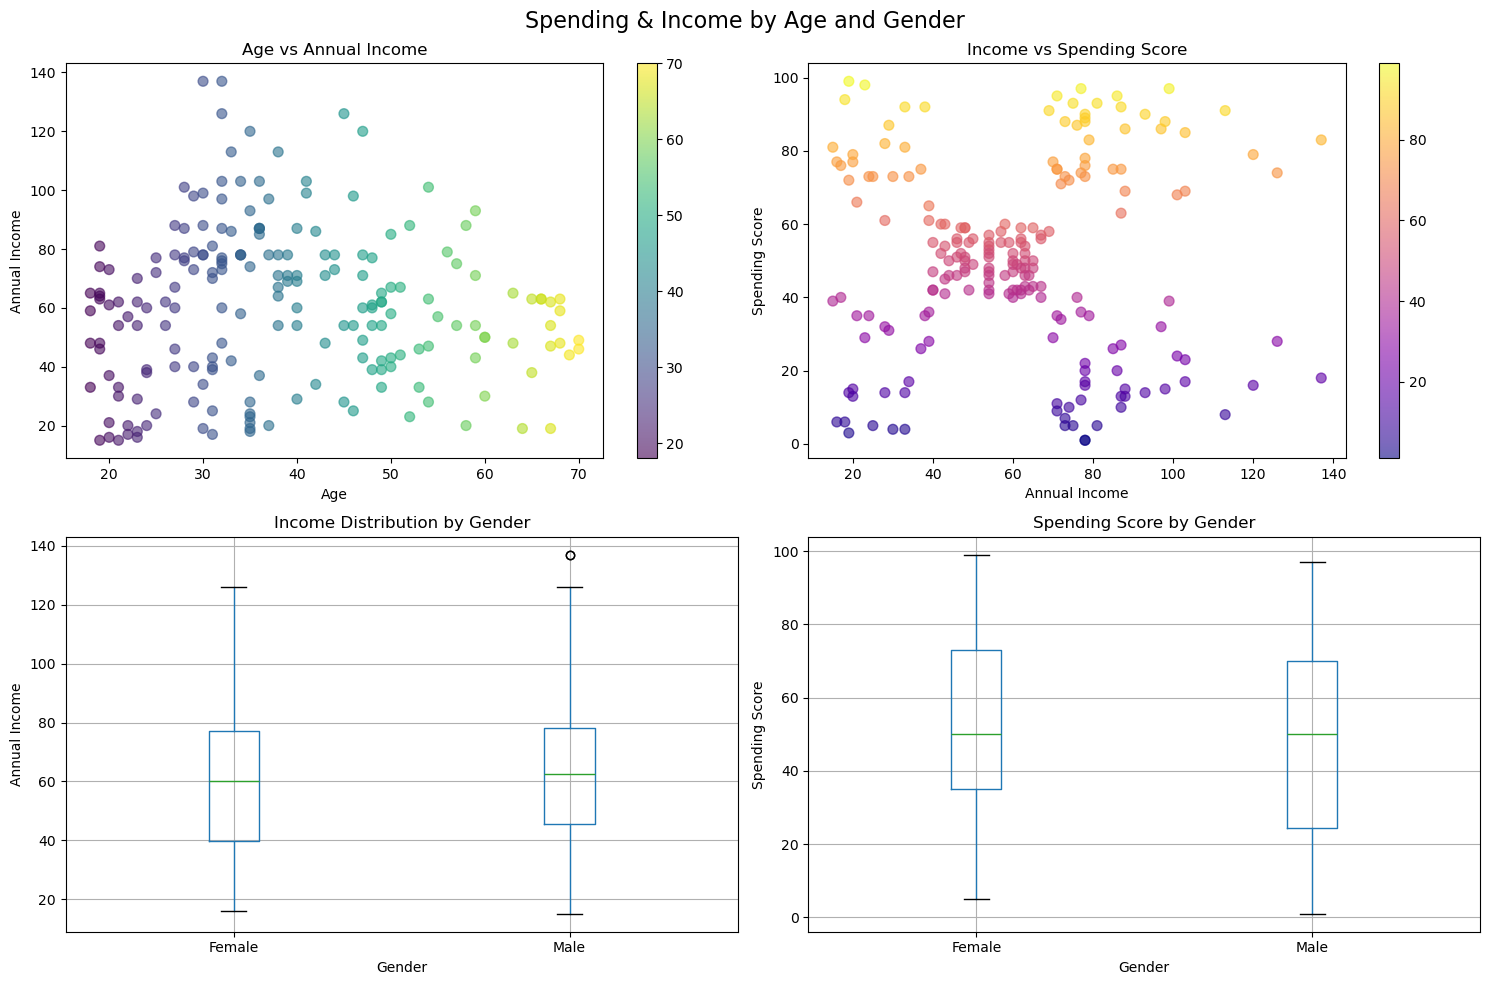

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# fig.suptitle('Spending & Income by Age and Gender', fontsize=16, y=0.98)
# plt.suptitle("") 



# Age vs Income scatter
    
scatter = axes[0,0].scatter(customer['Age'], customer['Annual Income (k$)'], alpha=0.6, c=customer['Age'], 
                                  cmap='viridis', s=50)
axes[0,0].set_title('Age vs Annual Income')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Annual Income')
plt.colorbar(scatter, ax=axes[0,0])


# Income vs Spending Score scatter
   
scatter = axes[0,1].scatter(customer['Annual Income (k$)'], customer['Spending Score (1-100)'], alpha=0.6, 
                                  c=customer['Spending Score (1-100)'], cmap='plasma', s=50)
axes[0,1].set_title('Income vs Spending Score')
axes[0,1].set_xlabel('Annual Income')
axes[0,1].set_ylabel('Spending Score')
plt.colorbar(scatter, ax=axes[0,1])

# plt.savefig('income_vs_spending.png', dpi=300, bbox_inches='tight')
    
#  Box plot of income by gender
customer.boxplot(column='Annual Income (k$)', by='Gender', ax=axes[1,0])
axes[1,0].set_title('Income Distribution by Gender')
axes[1,0].set_xlabel('Gender')
axes[1,0].set_ylabel('Annual Income')
    
#  Box plot of spending by gender
customer.boxplot(column='Spending Score (1-100)', by='Gender', ax=axes[1,1])
axes[1,1].set_title('Spending Score by Gender')
axes[1,1].set_xlabel('Gender')
axes[1,1].set_ylabel('Spending Score')
    
fig.suptitle('Spending & Income by Age and Gender', fontsize=16, y=0.98)


    
plt.tight_layout()
plt.show()
    

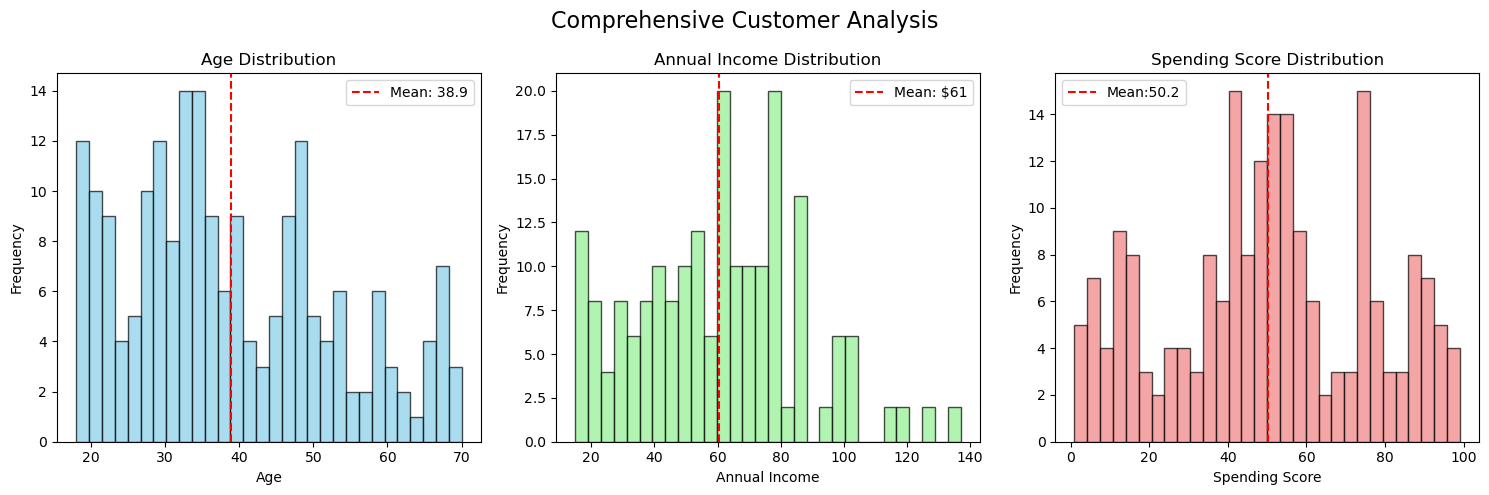

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Comprehensive Customer Analysis', fontsize=16, y=0.98)
    
 # Age distribution
    
axes[0].hist(customer['Age'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].axvline(customer['Age'].mean(), color='red', linestyle='--', 
                         label=f'Mean: {customer["Age"].mean():.1f}')
axes[0].legend()



# Income distribution
mean_income = customer['Annual Income (k$)'].mean()   
axes[1].hist(customer['Annual Income (k$)'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_title('Annual Income Distribution')
axes[1].set_xlabel('Annual Income')
axes[1].set_ylabel('Frequency')
axes[1].axvline(customer['Annual Income (k$)'].mean(), color='red', linestyle='--',
                         label=f'Mean: ${mean_income:,.0f}')

                        
axes[1].legend()


 # Spending score distribution
mean_spending=customer['Spending Score (1-100)'].mean()    
axes[2].hist(customer['Spending Score (1-100)'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2].set_title('Spending Score Distribution')
axes[2].set_xlabel('Spending Score')
axes[2].set_ylabel('Frequency')
axes[2].axvline(customer['Spending Score (1-100)'].mean(), color='red', linestyle='--',
                         label=f'Mean:{mean_spending:.1f}')
                         
axes[2].legend()

plt.tight_layout()
plt.show()

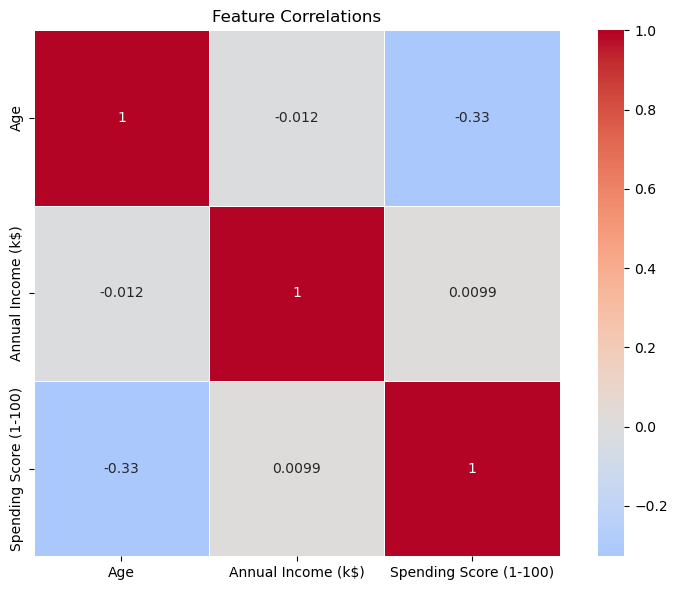

In [91]:
#  Correlation heatmap
plt.figure(figsize=(8,6))
numeric_df = customer.select_dtypes(include=[np.number]).iloc[:, 1:]
if len(numeric_df.columns) > 1:
    correlation = numeric_df.corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5)
    plt.title('Feature Correlations')
    
    plt.tight_layout()
    plt.show()

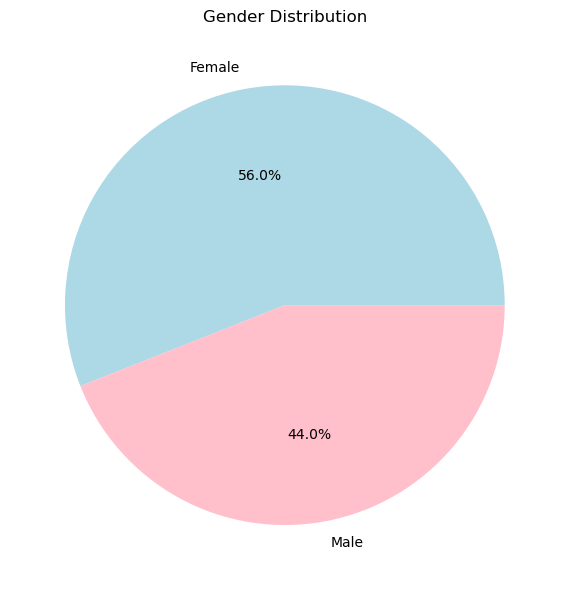

In [47]:
# Gender distribution
plt.figure(figsize=(8,6))    
gender_counts = customer['Gender'].value_counts()
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
                     colors=['lightblue', 'pink'])
plt.title('Gender Distribution')

plt.tight_layout()
plt.show()

## Feature Engineering and Scaling

In [92]:
X=customer[['Annual Income (k$)',
       'Spending Score (1-100)']].copy()

In [94]:
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

X_scaled= pd.DataFrame(X_scaled, columns=['Income', 'Spending_Score'])

In [95]:
X_scaled.head()

,Income,Spending_Score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


In [97]:
from sklearn.cluster import KMeans

# Within-Cluster Sum of Squares
wcss=[]

for k in range(1,11):
    kmeans= KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

print(wcss)

[399.9999999999999, 269.6910121927639, 157.70400815035947, 108.92131661364357, 65.56840815571681, 55.05734827038599, 44.86475569922557, 37.22818767758588, 32.39226763033117, 29.981897788243696]


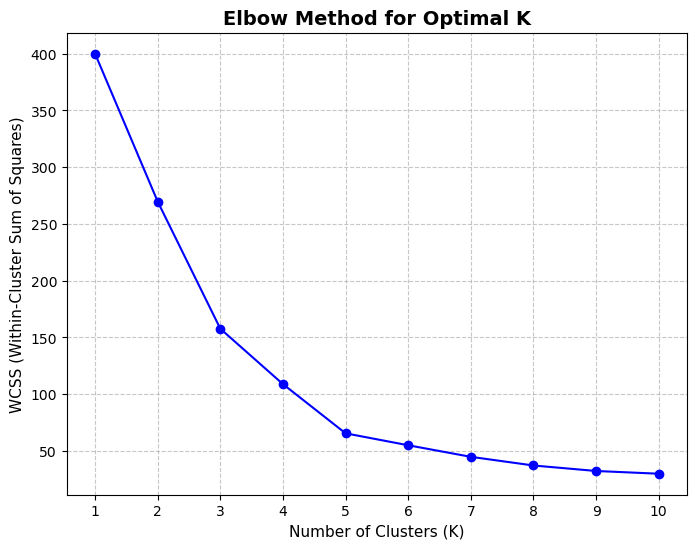

In [143]:

plt.figure(figsize=(8,6))

plt.plot(range(1,11), wcss, marker='o', linestyle="-", color='blue')
plt.title('Elbow Method for Optimal K', fontsize=14, weight='bold')
plt.xlabel('Number of Clusters (K)', fontsize=11)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1,11))
plt.savefig(os.path.join("../reports/",'elbow_method.png'), dpi=300, bbox_inches='tight')

plt.show()


The optimal k is k=5

In [101]:
kmeans_opt= KMeans(n_clusters=5, random_state=42, n_init=10)
clusters=kmeans_opt.fit_predict(X_scaled)

customer['Cluster']= clusters
customer.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,2
2,3,Female,20,16,6,4
3,4,Female,23,16,77,2
4,5,Female,31,17,40,4


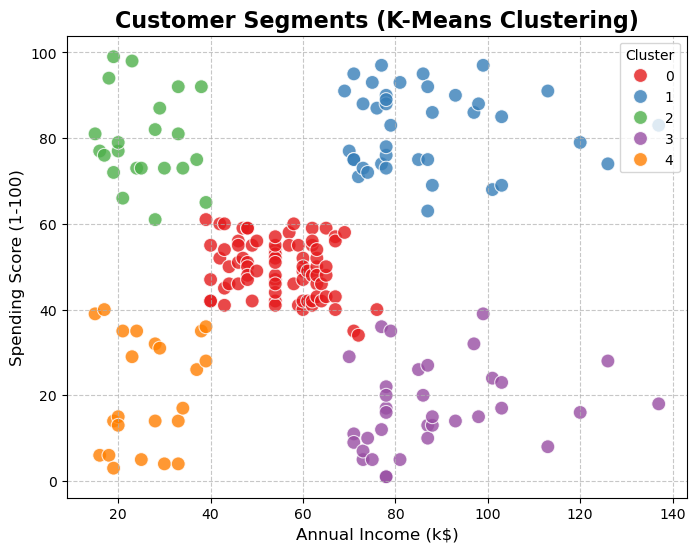

In [102]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=customer,
                 x='Annual Income (k$)',
                 y='Spending Score (1-100)',
                hue='Cluster', 
                palette='Set1',
                s=100, 
                alpha=0.8
               )

plt.title('Customer Segments (K-Means Clustering)', fontsize=16, weight='bold')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [103]:
cluster_summary= customer.groupby('Cluster').agg({
     'Annual Income (k$)':'mean', 
     'Spending Score (1-100)':'mean', 
     'CustomerID': 'count'
}).round(2)

cluster_summary.colums=['Avg_Income', 'Avg_Spending_Score', 'Count'] 
print(cluster_summary)

         Annual Income (k$)  Spending Score (1-100)  CustomerID
Cluster                                                        
0                     55.30                   49.52          81
1                     86.54                   82.13          39
2                     25.73                   79.36          22
3                     88.20                   17.11          35
4                     26.30                   20.91          23


### Business insights based on each cluster 


**Cluster(0)- The first Cluster as they indexed from 0**
    Those are the middle group with middle values on avergae for income and spending and those atr the majority of customers with a customer size 81
    Create loyality programs to retain them. target them with seasonal promotions.

**Cluster(1)- Second Cluster** 
    Their income is high and their spending is the highest ( in other words they earn a lot and spend a lot) with a size of 39 customers
    Those should be targeted with high-end marketing, offering them loyality awards and premium products and services.

**Cluster(2)- Third Cluster**
    Those are with the lowest income but the second ranking in spending scores with customer size of 22
    offering them installement plans as they have the motivation to buy even with their low  income.

**Cluster(3)- Fourth cluster**
    Those tend to earn the highest with the lowest spending score with a customer size 35, they are wealthy but cautious "Savers"
    Those should be targeted with bundles and discounts that offer them savings and encourage them to spend.

**Cluster(4)- Fifth Cluster**
    Those are low income and low spending with a customer size of 23 
    Those can be targeted with the lowest-price items and budget-friendly tags

    

## DBSCAN

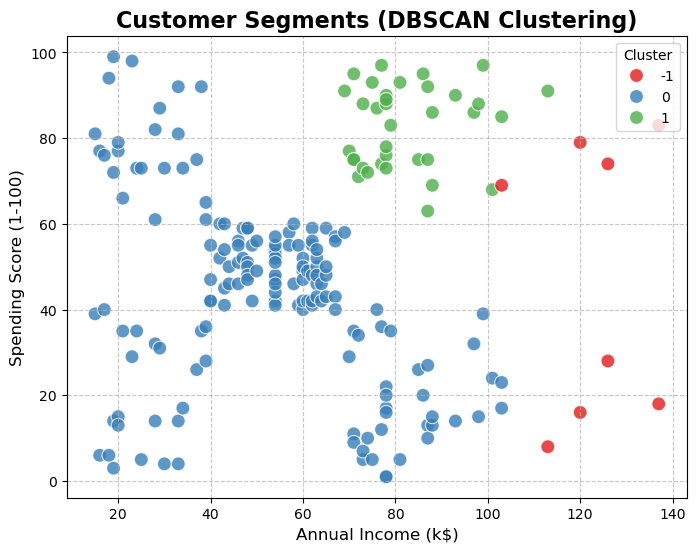

In [104]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)

clusters_db= dbscan.fit_predict(X_scaled)
customer["Cluster_DBSCAN"]= clusters_db


plt.figure(figsize=(8,6))
sns.scatterplot(data=customer,
                x='Annual Income (k$)',
                y='Spending Score (1-100)',
                hue='Cluster_DBSCAN',
                palette='Set1',
                s=100,
                alpha=0.8
               )

plt.title('Customer Segments (DBSCAN Clustering)', fontsize=16, weight='bold')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [105]:
print(customer.groupby('Cluster_DBSCAN').size())

Cluster_DBSCAN
-1      8
 0    157
 1     35
dtype: int64


In [134]:

for eps in [0.1, 0.2, 0.3, 0.4, 0.5,0.6]:
    dbscan_op = DBSCAN(eps=eps, min_samples=5)
    clusters_dbscan_op = dbscan_op.fit_predict(X_scaled)
    print(f"eps={eps}: {len(np.unique(clusters_dbscan_op))} clusters, {np.sum(clusters_dbscan_op == -1)} outliers")
    


eps=0.1: 5 clusters, 166 outliers
eps=0.2: 8 clusters, 77 outliers
eps=0.3: 8 clusters, 35 outliers
eps=0.4: 5 clusters, 15 outliers
eps=0.5: 3 clusters, 8 outliers
eps=0.6: 2 clusters, 5 outliers


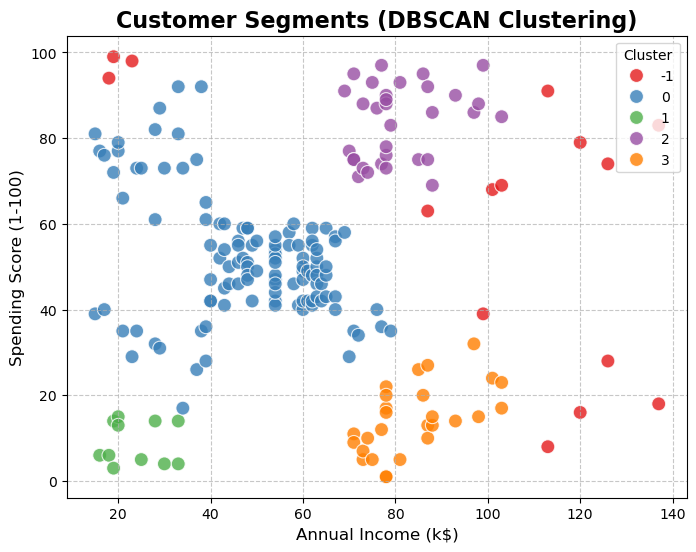

In [136]:

dbscan_op = DBSCAN(eps=0.4, min_samples=5)

clusters_dbscan_op = dbscan_op.fit_predict(X_scaled)



customer["Cluster_DBSCAN_OP"]= clusters_dbscan_op


plt.figure(figsize=(8,6))
sns.scatterplot(data=customer,
                x='Annual Income (k$)',
                y='Spending Score (1-100)',
                hue='Cluster_DBSCAN_OP',
                palette='Set1',
                s=100,
                alpha=0.8
               )

plt.title('Customer Segments (DBSCAN Clustering)', fontsize=16, weight='bold')
plt.xlabel('Annual Income (k$)', fontsize=12)
plt.ylabel('Spending Score (1-100)', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The Blue Cluster mainstream customers

Green Cluster `low income low spending`

Purple Cluster `high income high spending`

Orange Clsuter `high income low spending` 

Red dots scatter at edges represent outliers- These requires further investigation:

    * some are low income and high spending 
    * others are very high income and very low spending 
    * some high income and high spending 

In [137]:

# kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# clusters_kmeans = kmeans.fit_predict(X_scaled)

# # DBSCAN with eps=0.4
# dbscan_op = DBSCAN(eps=0.4, min_samples=5)
# clusters_dbscan = dbscan_op.fit_predict(X_scaled)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'CustomerID': customer['CustomerID'],
    'KMeans_Cluster': clusters,
    'DBSCAN_Cluster': clusters_dbscan_op
})

print("****************** Cluster Comparison *********************")
print(comparison_df.head())

****************** Cluster Comparison *********************
   CustomerID  KMeans_Cluster  DBSCAN_Cluster
0           1               4               0
1           2               2               0
2           3               4               1
3           4               2               0
4           5               4               0


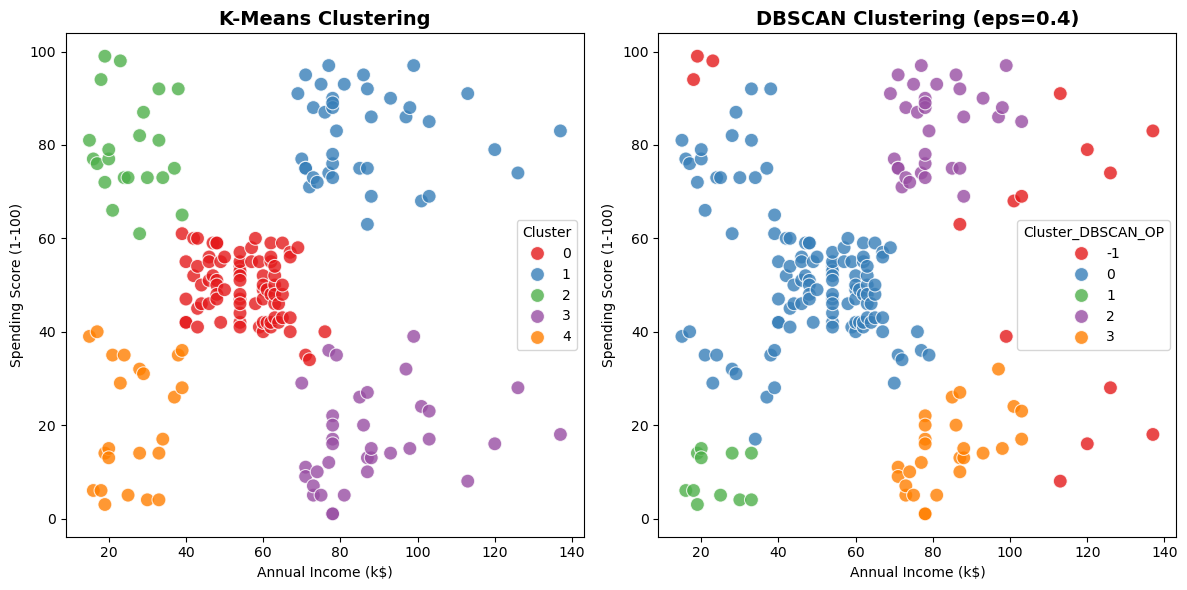

Disagreement Rate: 46.00% of customers assigned to different clusters


In [138]:
# customer["Cluster_DBSCAN_OP"]= clusters_dbscan_op
# customer['Cluster']= clusters
customer['Cluster_Agreement']= (customer['Cluster']== customer['Cluster_DBSCAN_OP'])

# Plot disagreements
plt.figure(figsize=(12,6))

# Plot 1: K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(data=customer,
                x='Annual Income (k$)',
                y='Spending Score (1-100)',
                hue='Cluster',
                palette='Set1',
                s=100, alpha=0.8)
plt.title('K-Means Clustering', fontsize=14, weight='bold')

# Plot 2: DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=customer,
                x='Annual Income (k$)',
                y='Spending Score (1-100)',
                hue='Cluster_DBSCAN_OP',
                palette='Set1',
                s=100, alpha=0.8)
plt.title('DBSCAN Clustering (eps=0.4)', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# Show disagreement rate
disagreement_rate = 1 - customer['Cluster_Agreement'].mean()
print(f"Disagreement Rate: {disagreement_rate:.2%} of customers assigned to different clusters")